In [ ]:

import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Entry, Button, Label, Listbox, SINGLE, END, Frame, StringVar, OptionMenu
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd

# Fungsi untuk mengambil spektrum yang telah diproses dari database
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mengambil data NIST berdasarkan panjang gelombang dari database data1.db
def get_nist_lines_for_wavelength(db_nist, wavelength_range):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Tambahkan sp_num ke query
    query = """
        SELECT "obs_wl_air(nm)", element, "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", sp_num
        FROM spectrum_data
        WHERE "obs_wl_air(nm)" BETWEEN ? AND ?
    """
    cursor.execute(query, wavelength_range)
    nist_lines = cursor.fetchall()
    conn.close()

    if not nist_lines:
        print(f"Tidak ada data dari data1.db untuk rentang panjang gelombang {wavelength_range}")
    else:
        print(f"Ditemukan {len(nist_lines)} garis unsur dari data1.db dalam rentang {wavelength_range}")
    return nist_lines

# Fungsi untuk plotting spektrum dari database dan menampilkan di canvas
def plot_spectrum_with_peaks(wavelengths, intensities, lower_bound, peak_listbox, canvas_frame):
    upper_bound = lower_bound + 1

    # Filter data sesuai dengan rentang batas bawah dan atas
    mask = (wavelengths >= lower_bound) & (wavelengths <= upper_bound)
    wavelengths_filtered = wavelengths[mask]
    intensities_filtered = intensities[mask]

    # Buat plot di canvas Tkinter
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(wavelengths_filtered, intensities_filtered, label='Experimental Data', color='blue')

    # Mencari puncak dalam rentang panjang gelombang yang dipilih
    peaks, _ = find_peaks(intensities_filtered)
    
    # Kosongkan Listbox sebelum menambahkan puncak baru
    peak_listbox.delete(0, END)

    # Buat daftar puncak dan intensitas
    peaks_with_intensity = [(wavelengths_filtered[peak], intensities_filtered[peak]) for peak in peaks]

    # Urutkan berdasarkan intensitas (dari yang tertinggi ke terendah)
    peaks_with_intensity_sorted = sorted(peaks_with_intensity, key=lambda x: x[1], reverse=True)

    # Tampilkan puncak yang sudah diurutkan di Listbox
    for wl, intensity in peaks_with_intensity_sorted:
        peak_listbox.insert(END, f"{wl:.6f} nm, Intensity: {intensity:.6f}")

        # Plot titik puncak tanpa label
        ax.scatter(wl, intensity, color='red', marker='.')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.grid(True)

    # Tampilkan plot di canvas Tkinter
    canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=0, column=1, padx=10)

# Fungsi untuk memperbarui plot berdasarkan nilai input
def get_processed_spectrum_for_sample(sample_name):
    try:
        wavelengths, intensities = get_processed_spectra_with_metadata(db_path, sample_name)
        return wavelengths, intensities
    except Exception as e:
        print(f"Error membaca data spektrum: {e}")
        return np.array([]), np.array([])

# Fungsi untuk memperbarui plot berdasarkan nilai input dan sampel yang dipilih
def update_plot():
    try:
        sample_name = selected_sample.get()
        global wavelengths, intensities
        wavelengths, intensities = get_processed_spectrum_for_sample(sample_name)

        if len(wavelengths) == 0 or len(intensities) == 0:
            print(f"Tidak ada data spektrum untuk sampel {sample_name}")
            return

        lower_bound = float(lower_entry.get())
        
        for widget in canvas_frame.winfo_children():
            widget.destroy()

        plot_spectrum_with_peaks(wavelengths, intensities, lower_bound, peak_listbox, canvas_frame)
    except ValueError:
        print("Masukkan nilai numerik yang valid untuk batas bawah panjang gelombang.")

# Fungsi untuk menambahkan puncak yang dipilih ke daftar selected_peaks dan menampilkan daftar unsur
def show_selected_peak():
    selected = peak_listbox.curselection()
    if selected:
        peak_info = peak_listbox.get(selected)
        wavelength_str, intensity_str = peak_info.split(", Intensity:")
        wavelength = float(wavelength_str.split()[0])
        intensity = float(intensity_str.strip())
        
        # Cari unsur dari NIST berdasarkan puncak yang dipilih
        nist_lines = get_nist_lines_for_wavelength(db_nist, (wavelength - 0.1, wavelength + 0.1))
        
        element_listbox.delete(0, END)

        for line in nist_lines:
            wl_nist, element, gA, Ek, Ei, sp_num = line
            try:
                wl_nist = float(wl_nist)
                gA_str = f"{float(gA):.2e}" if gA != '' else "N/A"
                Ek_eV = float(Ek) / 8065.54
                Ei_eV = float(Ei) / 8065.54
            except ValueError:
                wl_nist = gA_str = Ek_eV = Ei_eV = "N/A"
            element_listbox.insert(END, f"Unsur: {element}, sp_num: {sp_num}, Wavelength: {wl_nist}, gA: {gA_str}, Ek: {Ek_eV}, Ei: {Ei_eV}")

        selected_peaks.append({'wavelength': wavelength, 'intensity': intensity, 'nist_lines': nist_lines})
        print(f"Puncak yang dipilih: Panjang Gelombang = {wavelength}, Intensitas = {intensity}")

def select_element():
    selected = element_listbox.curselection()
    if selected and selected_peaks:
        peak = selected_peaks[-1]
        element_info = element_listbox.get(selected)
        peak['selected_element_info'] = element_info
        print(f"Unsur yang dipilih: {element_info}")

def save_peaks_to_excel():
    data = []
    for peak in selected_peaks:
        if 'selected_element_info' in peak:
            element_info = peak['selected_element_info']
            element_info_split = element_info.split(', ')
            
            if len(element_info_split) >= 4:
                wl_nist = element_info_split[2].split(': ')[1]
                element = element_info_split[0].split(': ')[1]
                sp_num = element_info_split[1].split(': ')[1]
                gA = element_info_split[3].split(': ')[1]
                Ek = element_info_split[4].split(': ')[1]
                Ei = element_info_split[5].split(': ')[1]
                
                data.append({
                    'Panjang Gelombang (nm)': peak['wavelength'],
                    'Intensitas': peak['intensity'],
                    'Unsur': element,
                    'sp_num': sp_num,
                    'Wavelength NIST (nm)': wl_nist,
                    'gA (s^-1)': gA,
                    'Ek (eV)': Ek,
                    'Ei (eV)': Ei
                })
    
    if data:
        df = pd.DataFrame(data)
        df.columns = ['Panjang Gelombang (nm)', 'Intensitas', 'Unsur', 'sp_num', 'Wavelength NIST (nm)', 'gA', 'Ek (eV)', 'Ei (eV)']
        
        df.to_excel("selected_peaks_with_nist.xlsx", index=False)
        print("Data puncak dan unsur yang dipilih telah disimpan ke selected_peaks_with_nist.xlsx")
    else:
        print("Tidak ada data untuk disimpan.")

# Path ke database dan nama sampel
db_path = 'processed_spectra.db'
db_nist = 'data1.db'

# List untuk menyimpan puncak yang dipilih
selected_peaks = []

# Membuat GUI menggunakan Tkinter
root = Tk()
root.title("Spectrum Analyzer")

# Frame utama untuk menampilkan elemen-elemen GUI
main_frame = Frame(root)
main_frame.grid(row=0, column=0)

# Dropdown untuk memilih sampel (S1-S24)
sample_label = Label(main_frame, text="Pilih Sampel:")
sample_label.grid(row=0, column=0)
selected_sample = StringVar(root)
selected_sample.set("S1")  # Default sampel adalah S1
sample_menu = OptionMenu(main_frame, selected_sample, *[f'S{i}' for i in range(1, 25)])
sample_menu.grid(row=0, column=1)

# Label dan Entry untuk input batas bawah panjang gelombang
label1 = Label(main_frame, text="Masukkan Batas Bawah Panjang Gelombang (Batas Atas +3 nm):")
label1.grid(row=1, column=0)
lower_entry = Entry(main_frame)
lower_entry.grid(row=1, column=1)

# Tombol untuk memperbarui plot
button = Button(main_frame, text="Tampilkan Plot", command=update_plot)
button.grid(row=2, column=0, columnspan=2)

# Listbox untuk menampilkan puncak yang ditemukan
peak_listbox = Listbox(main_frame, selectmode=SINGLE, height=5, width=40)
peak_listbox.grid(row=3, column=0, columnspan=2)

# Tombol untuk konfirmasi puncak yang dipilih
select_button = Button(main_frame, text="Pilih Puncak", command=show_selected_peak)
select_button.grid(row=4, column=0, columnspan=2)

# Listbox untuk menampilkan unsur dari data1.db
element_listbox = Listbox(main_frame, selectmode=SINGLE, height=5, width=80)
element_listbox.grid(row=5, column=0, columnspan=2)

# Tombol untuk konfirmasi unsur yang dipilih
select_element_button = Button(main_frame, text="Pilih Unsur", command=select_element)
select_element_button.grid(row=6, column=0, columnspan=2)

# Tombol untuk menyimpan data puncak dan unsur yang dipilih ke dalam Excel
save_button = Button(main_frame, text="Simpan ke Excel", command=save_peaks_to_excel)
save_button.grid(row=7, column=0, columnspan=2)

# Frame untuk menampilkan plot di sebelah kanan
canvas_frame = Frame(root)
canvas_frame.grid(row=0, column=1, padx=10)

# Jalankan GUI
root.mainloop()

2024-11-10 21:54:08.306 Python[5610:274571] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-10 21:54:08.306 Python[5610:274571] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Ditemukan 59 garis unsur dari data1.db dalam rentang (343.97177999999997, 344.17178)
Puncak yang dipilih: Panjang Gelombang = 344.07178, Intensitas = 0.036029
Ditemukan 51 garis unsur dari data1.db dalam rentang (368.42334999999997, 368.62335)
Puncak yang dipilih: Panjang Gelombang = 368.52335, Intensitas = 0.031516


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

alpha = 1.0  # Dispersion constant
beta = 1.0  # Nonlinearity constant

N = 1024  # Number of spatial points (frequency domain)
L = 100  # Length of the domain
dx = L / N
x = np.linspace(-L/2, L/2, N)

dt = 0.01  # Time step
T = 2.0  # Total time
timesteps = int(T / dt)

A = 1.0  # Amplitude
sigma = 5.0  # Width of the initial spectrum
psi_0 = A * np.exp(-x**2 / (2 * sigma**2))  # Initial pulse

k = fftfreq(N, d=dx) * 2 * np.pi

def evolve_psi(psi, dx, dt, alpha, beta):
    psi_k = fft(psi)
    psi_k = psi_k * np.exp(-1j * alpha * k**2 * dt / 2)
    psi_disp = ifft(psi_k)
    
    psi_nonlin = psi_disp * np.exp(1j * beta * np.abs(psi_disp)**2 * dt)
    
    psi_k = fft(psi_nonlin)
    psi_k = psi_k * np.exp(-1j * alpha * k**2 * dt / 2)
    
    return ifft(psi_k)

psi = psi_0

psi_data = []

for t in range(timesteps):
    psi = evolve_psi(psi, dx, dt, alpha, beta)
    if t % (timesteps // 100) == 0:
        psi_data.append(np.abs(psi))

plt.figure(figsize=(10, 6))
plt.plot(x, np.abs(psi_0), label="Initial Spectrum", linestyle="--")
plt.plot(x, np.abs(psi), label="Evolved Spectrum (Nonlinear Effects)")
plt.title('Evolution of LIBS Spectrum Under Nonlinear Effects (NLS)')
plt.xlabel('Wavelength (arbitrary units)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n2 = 1e-20  # Nonlinear index (example value for Kerr medium)
L = 1.0     # Length of the medium in meters
lambda_0 = 800e-9  # Wavelength of the light in meters
c = 3e8     # Speed of light in vacuum

t = np.linspace(-50, 50, 1000)  # Time in fs
omega_0 = 2 * np.pi * c / lambda_0  # Central frequency

I_peak = 1.0  # Peak intensity
tau = 10.0    # Pulse width (FWHM in fs)
I_t = I_peak * np.exp(-t**2 / (2 * tau**2))  # Gaussian intensity profile

delta_phi = (2 * np.pi / lambda_0) * n2 * I_t * L

omega_t = omega_0 + np.gradient(delta_phi, t)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, I_t, label='Pulse Intensity')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (a.u.)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, omega_t - omega_0, label='Frequency Shift due to SPM')
plt.xlabel('Time (fs)')
plt.ylabel('Frequency Shift (rad/fs)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n2 = 1e-20  # Nonlinear index (Kerr medium example value)
L = 1.0     # Length of plasma in meters (example value)
lambda_0 = 800e-9  # Wavelength of the laser light (800 nm)
c = 3e8     # Speed of light in vacuum (m/s)

t = np.linspace(-50, 50, 1000)  # Time in fs (pulse duration)
omega_0 = 2 * np.pi * c / lambda_0  # Central frequency (rad/s)

I_peak = 1.0  # Peak intensity
tau = 10.0    # Pulse duration (FWHM in fs)
I_t = I_peak * np.exp(-t**2 / (2 * tau**2))  # Gaussian intensity profile (normalized)

delta_phi = (2 * np.pi / lambda_0) * n2 * I_t * L  # Phase shift in radians

omega_t = omega_0 + np.gradient(delta_phi, t)  # Instantaneous frequency

spectrum_initial = np.abs(np.fft.fftshift(np.fft.fft(I_t)))  # Initial spectrum (Gaussian)
spectrum_broadened = np.abs(np.fft.fftshift(np.fft.fft(np.exp(1j * delta_phi))))  # Broadened spectrum due to SPM

freq = np.fft.fftshift(np.fft.fftfreq(len(t), (t[1] - t[0])))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, I_t, label='Intensity (Gaussian)')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (a.u.)')
plt.grid(True)
plt.title('Initial Intensity Profile of LIBS Spectrum')

plt.subplot(3, 1, 2)
plt.plot(t, omega_t - omega_0, label='Frequency Shift due to SPM')
plt.xlabel('Time (fs)')
plt.ylabel('Frequency Shift (rad/fs)')
plt.grid(True)
plt.title('Frequency Shift due to SPM (Nonlinear Phase)')

plt.subplot(3, 1, 3)
plt.plot(freq, spectrum_initial / np.max(spectrum_initial), label='Initial Spectrum')
plt.plot(freq, spectrum_broadened / np.max(spectrum_broadened), label='Broadened Spectrum (SPM)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude (Normalized)')
plt.legend()
plt.grid(True)
plt.title('Effect of Self-Phase Modulation on LIBS Spectrum')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

def apply_spm_nls_to_spectrum(db_path, sample_name, lower_bound=None, upper_bound=None):
    wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)

    if len(wavelengths) == 0:
        return

    alpha = 1.0  # Dispersion constant
    beta = 1.0   # Nonlinearity constant
    L = 1.0      # Length of plasma (example)
    lambda_0 = np.mean(wavelengths) * 1e-9  # Approximate central wavelength (in meters)

    N = len(wavelengths)
    dx = (wavelengths[-1] - wavelengths[0]) / N
    dt = 0.01  # Time step
    T = 2.0  # Total time
    timesteps = int(T / dt)

    psi = intensities

    psi_data = []

    def evolve_psi(psi, dx, dt, alpha, beta):
        k = np.fft.fftfreq(N, d=dx) * 2 * np.pi
        psi_k = np.fft.fft(psi)
        psi_k = psi_k * np.exp(-1j * alpha * k**2 * dt / 2)
        psi_disp = np.fft.ifft(psi_k)
        
        psi_nonlin = psi_disp * np.exp(1j * beta * np.abs(psi_disp)**2 * dt)
        
        psi_k = np.fft.fft(psi_nonlin)
        psi_k = psi_k * np.exp(-1j * alpha * k**2 * dt / 2)
        
        return np.fft.ifft(psi_k)

    for t in range(timesteps):
        psi = evolve_psi(psi, dx, dt, alpha, beta)
        if t % (timesteps // 100) == 0:  # Store every 100th frame
            psi_data.append(np.abs(psi))

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(wavelengths, intensities, label=f'Original Spectrum: {sample_name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (a.u.)')
    plt.title(f'Original LIBS Spectrum for {sample_name}')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(wavelengths, np.abs(psi), label='Evolved Spectrum (NLS)')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Amplitude (Evolved)')
    plt.title('Evolved Spectrum due to Nonlinear Schrödinger Equation')
    plt.grid(True)

    delta_phi = (2 * np.pi / lambda_0) * beta * intensities * L  # Phase shift due to SPM
    spectrum_broadened = np.abs(np.fft.fftshift(np.fft.fft(np.exp(1j * delta_phi))))
    spectrum_broadened /= np.max(spectrum_broadened)  # Normalize

    plt.subplot(3, 1, 3)
    plt.plot(wavelengths, spectrum_broadened, label='Broadened Spectrum (SPM)')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Amplitude (Normalized)')
    plt.title('Broadened LIBS Spectrum due to Self-Phase Modulation')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

db_path = 'processed_spectra.db'
sample_name = 'S1'  # Ganti dengan nama sampel yang sesuai di database Anda
lower_bound = 200.5  # Batas panjang gelombang bawah (nm)
upper_bound = 900.5  # Batas panjang gelombang atas (nm)

apply_spm_nls_to_spectrum(db_path, sample_name, lower_bound, upper_bound)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.special import wofz
import sqlite3

def voigt_profile(x, amp, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

def smooth_spectrum(intensities, window_length=11, polyorder=2):
    return savgol_filter(intensities, window_length, polyorder)

def fit_voigt_profile(wavelengths, intensities):
    initial_guess = [np.max(intensities), wavelengths[np.argmax(intensities)], 0.1, 0.1]

    popt, pcov = curve_fit(voigt_profile, wavelengths, intensities, p0=initial_guess)
    fitted_profile = voigt_profile(wavelengths, *popt)

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label='Data Spektrum Asli')
    plt.plot(wavelengths, fitted_profile, label='Fitting Voigt Profile', linestyle='--')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas (a.u.)')
    plt.title('Fitting Spektrum dengan Voigt Profile Setelah Smoothing')
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt, fitted_profile

def process_spectrum_with_smoothing_voigt(db_path, sample_name, lower_bound=None, upper_bound=None):
    wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
    
    if len(wavelengths) == 0:
        print("Tidak ada spektrum yang ditemukan.")
        return
    
    smoothed_intensities = smooth_spectrum(intensities)

    popt, fitted_profile = fit_voigt_profile(wavelengths, smoothed_intensities)

    print(f"Parameter hasil fitting Voigt setelah smoothing: {popt}")

db_path = 'processed_spectra.db'  # Path ke database
sample_name = 'S1'  # Nama sampel di database
lower_bound = 396.5  # Batas panjang gelombang bawah (nm)
upper_bound = 397.5  # Batas panjang gelombang atas (nm)

process_spectrum_with_smoothing_voigt(db_path, sample_name, lower_bound, upper_bound)

In [ ]:
import sqlite3
import numpy as np

def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM spectrum_data
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

def apply_baseline_correction(wavelengths, intensities):
    baseline = baseline_als(intensities)
    corrected_intensities = intensities - baseline
    return corrected_intensities, baseline

def fwhm_voigt(sigma, gamma):
    return 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2 * sigma)**2)

def calculate_fwhm_from_voigt_fit(popt):
    sigma = popt[2]
    gamma = popt[3]
    fwhm = fwhm_voigt(sigma, gamma)
    return fwhm

def process_spectrum_with_baseline_and_fwhm(db_path, sample_name, lower_bound=None, upper_bound=None):
    wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
    
    if len(wavelengths) == 0:
        print(f"Tidak ada spektrum yang ditemukan untuk sampel: {sample_name}")
        return

    corrected_intensities, baseline = apply_baseline_correction(wavelengths, intensities)
    
    smoothed_intensities = smooth_spectrum(corrected_intensities)
    
    popt, fitted_profile = fit_voigt_profile(wavelengths, smoothed_intensities)
    
    fwhm = calculate_fwhm_from_voigt_fit(popt)
    print(f"FWHM dari profil Voigt: {fwhm:.4f} nm")

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(wavelengths, intensities, label='Spektrum Asli')
    plt.plot(wavelengths, baseline, label='Baseline', linestyle='--')
    plt.plot(wavelengths, corrected_intensities, label='Setelah Baseline Correction')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas (a.u.)')
    plt.title(f'Baseline Correction pada Sampel {sample_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(wavelengths, smoothed_intensities, label='Setelah Smoothing')
    plt.plot(wavelengths, fitted_profile, label='Profil Voigt yang di-fit', linestyle='--')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas (a.u.)')
    plt.title('Smoothing dan Fitting Voigt Setelah Baseline Correction')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

db_path = 'tanah_vulkanik.db'  # Path ke database
sample_name = 'S1'  # Nama sampel
lower_bound = 396.5  # Batas panjang gelombang bawah
upper_bound = 397.5  # Batas panjang gelombang atas

process_spectrum_with_baseline_and_fwhm(db_path, sample_name, lower_bound, upper_bound)

In [ ]:
import numpy as np

def fwhm_voigt(sigma, gamma):
    return 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2 * sigma)**2)

def calculate_fwhm_from_voigt_fit(popt):
    sigma = popt[2]
    gamma = popt[3]
    
    fwhm = fwhm_voigt(sigma, gamma)
    return fwhm

def process_spectrum_with_fwhm(db_path, sample_name, lower_bound=None, upper_bound=None):
    wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
    
    if len(wavelengths) == 0:
        print("Tidak ada spektrum yang ditemukan.")
        return
    
    smoothed_intensities = smooth_spectrum(intensities)

    popt, fitted_profile = fit_voigt_profile(wavelengths, smoothed_intensities)

    fwhm = calculate_fwhm_from_voigt_fit(popt)
    print(f"FWHM dari profil Voigt: {fwhm:.4f} nm")

    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, intensities, label='Spektrum Asli')
    plt.plot(wavelengths, fitted_profile, label='Profil Voigt yang di-fit', linestyle='--')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas (a.u.)')
    plt.title(f'FWHM dari Profil Voigt untuk Sampel {sample_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

process_spectrum_with_fwhm(db_path, sample_name, lower_bound, upper_bound)

In [ ]:
import matplotlib.pyplot as plt

from simLIBS import simulation

libs = simulation.SimulatedLIBS(
    Te=0.6,
    Ne=10**18,
    elements=["Ca"],
    percentages=[100],
    resolution=1000,
    low_w=200,
    upper_w=1000,
    max_ion_charge=1,
    webscraping="static",
)

libs.plot(color="blue", title="W Fe Mo composition")
plt.savefig("output_data/plot_static.png")

Skipping entry with Ek=144941.10 and Ei=95350.60 due to conversion error.
Skipping entry with Ek=143166.76 and Ei=94084.96 due to conversion error.
Skipping entry with Ek=143170.04 and Ei=94147.46 due to conversion error.
Skipping entry with Ek=143165.4 and Ei=94147.46 due to conversion error.
Skipping entry with Ek=143170.04 and Ei=94268.68 due to conversion error.
Skipping entry with Ek=143166.76 and Ei=94268.68 due to conversion error.
Skipping entry with Ek=140095.7 and Ei=91274.50 due to conversion error.
Skipping entry with Ek=140091.9 and Ei=91274.50 due to conversion error.
Skipping entry with Ek=140090.0 and Ei=91274.50 due to conversion error.
Skipping entry with Ek=85481.35 and Ei=37453.91 due to conversion error.
Skipping entry with Ek=85481.35 and Ei=37577.79 due to conversion error.
Skipping entry with Ek=142961.20 and Ei=95350.60 due to conversion error.
Skipping entry with Ek=135022.127 and Ei=91274.50 due to conversion error.
Skipping entry with Ek=135015.701 and Ei=91

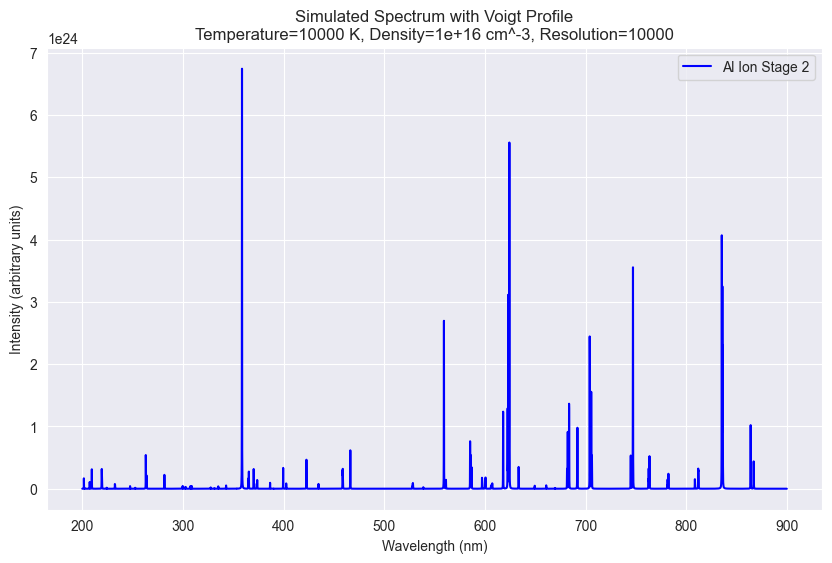

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz  # Untuk profil Voigt
import sqlite3

def get_spectral_data(db_path, element, sp_num):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, sp_num))
    data = cursor.fetchall()
    conn.close()
    return data

def calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density):
    k_B = 8.617333262145e-5  # eV/K
    boltzmann_factor = np.exp(-energy / (k_B * temperature))
    return einstein_coeff * degeneracy * boltzmann_factor * density

def voigt_profile(x, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def simulate_spectrum(db_path, element, sp_num, temperature, density, resolution):
    spectral_data = get_spectral_data(db_path, element, sp_num)
    wavelengths = np.linspace(200, 900, 7000)  # Rentang spektrum yang diinginkan
    intensities = np.zeros_like(wavelengths)

    for wl, gA, Ek, Ei in spectral_data:
        try:
            wl = float(wl)
            einstein_coeff = float(gA)
            Ek, Ei = float(Ek), float(Ei)
            energy = (Ek - Ei) / 8065.544  # Konversi cm^-1 ke eV
            degeneracy = 2  # Contoh; harus disesuaikan sesuai dengan data yang akurat
            intensity = calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density)
            
            sigma = wl / resolution  # Lebar Gaussian menyesuaikan dengan resolusi
            gamma = 0.05  # Lebar Lorentzian tetap, dapat disesuaikan lebih lanjut
            
            intensities += intensity * voigt_profile(wavelengths, wl, sigma, gamma)
        
        except ValueError:
            print(f"Skipping entry with Ek={Ek} and Ei={Ei} due to conversion error.")
            continue

    return wavelengths, intensities

def plot_simulated_spectrum(wavelengths, intensities, element, sp_num, temperature, density, resolution):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label=f'{element} Ion Stage {sp_num}', color='blue')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (arbitrary units)')
    plt.title(f'Simulated Spectrum with Voigt Profile\nTemperature={temperature} K, Density={density} cm^-3, Resolution={resolution}')
    plt.legend()
    plt.grid(True)
    plt.show()

db_path = 'data1.db'
element = 'Al'  # Contoh elemen
sp_num = 2     # Tahap ionisasi (misalnya, 1 untuk netral)
temperature = 10000  # Dalam Kelvin
density = 1e16  # Densitas partikel dalam cm^-3
resolution = 10000  # Resolusi spektrum

wavelengths, intensities = simulate_spectrum(db_path, element, sp_num, temperature, density, resolution)
plot_simulated_spectrum(wavelengths, intensities, element, sp_num, temperature, density, resolution)

In [ ]:
import numpy as np
import sqlite3
from scipy.special import wofz

def get_spectral_data(db_path, element, sp_num):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, sp_num))
    data = cursor.fetchall()
    conn.close()
    return data

def calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density):
    k_B = 8.617333262145e-5  # eV/K
    boltzmann_factor = np.exp(-energy / (k_B * temperature))
    return einstein_coeff * degeneracy * boltzmann_factor * density

def voigt_profile(x, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def simulate_spectrum(db_path, element, sp_num, temperature, density, resolution):
    spectral_data = get_spectral_data(db_path, element, sp_num)
    wavelengths = np.linspace(200, 900, resolution)  # Wavelength range with specified resolution
    intensities = np.zeros_like(wavelengths)

    for wl, gA, Ek, Ei in spectral_data:
        try:
            wl = float(wl)
            einstein_coeff = float(gA)
            Ek, Ei = float(Ek), float(Ei)
            energy = (Ek - Ei) / 8065.544  # Conversion from cm^-1 to eV
            degeneracy = 2  # Placeholder; should be modified based on accurate data
            intensity = calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density)
            
            sigma = 0.1  # Gaussian width (due to Doppler, instrument)
            gamma = 0.05  # Lorentzian width (natural, pressure)

            intensities += intensity * voigt_profile(wavelengths, wl, sigma, gamma)
        
        except ValueError:
            continue

    return wavelengths, intensities

def save_spectrum_to_db(conn, element, sp_num, temperature, density, wavelengths, intensities):
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS simulated_spectra (
            element TEXT,
            ion_stage INTEGER,
            temperature REAL,
            density REAL,
            wavelength REAL,
            intensity REAL
        )
    """)
    for wl, intensity in zip(wavelengths, intensities):
        cursor.execute("""
            INSERT INTO simulated_spectra (element, ion_stage, temperature, density, wavelength, intensity)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (element, sp_num, temperature, density, wl, intensity))
    conn.commit()

db_path = 'data1.db'
output_db_path = 'simulated_spectra.db'  # New database to save simulated spectra
resolution = 7000  # Adjusted resolution for finer spectra

num_combinations = len(list(temperature)) * len(list(density))
print(f"Total number of (temperature, density) combinations: {num_combinations}")

with sqlite3.connect(output_db_path) as conn:
    completed = 0
    for element in elements:
        for ion_stage in ion_stages:
            for temperature in temperature:
                for density in density:
                    wavelengths, intensities = simulate_spectrum(db_path, element, sp_num, temperature, density, resolution)
                    save_spectrum_to_db(conn, element, sp_num, temperature, density, wavelengths, intensities)
                    
                    completed += 1
                    progress = (completed / num_combinations) * 100
                    print(f"Progress: {progress:.2f}% ({completed}/{num_combinations} combinations completed)", end='\r')

print(f"\nAll spectra have been saved to {output_db_path}")

In [ ]:
import numpy as np
import sqlite3
from scipy.special import wofz
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder
import joblib  # For saving and loading the encoder

class a:
    @staticmethod
    def get_spectral_data(db_path, element, sp_num):
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    @staticmethod
    def save_spectrum_to_db(conn, sample_key, wavelengths, intensities):
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS simulated_spectra (
                sample_key TEXT,
                wavelength REAL,
                intensity REAL,
                PRIMARY KEY (sample_key, wavelength)
            )
        """)
        cursor.executemany("""
            INSERT OR REPLACE INTO simulated_spectra (sample_key, wavelength, intensity)
            VALUES (?, ?, ?)
        """, zip([sample_key]*len(wavelengths), wavelengths, intensities))
        conn.commit()

class b:
    @staticmethod
    def calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density):
        k_B = 8.617333262145e-5  # eV/K
        boltzmann_factor = np.exp(-energy / (k_B * temperature))
        return einstein_coeff * degeneracy * boltzmann_factor * density

    @staticmethod
    def voigt_profile(x, center, sigma, gamma):
        z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
        return np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

    @staticmethod
    def simulate_spectrum(db_path, element, sp_num, temperature, density, resolution):
        spectral_data = a.get_spectral_data(db_path, element, sp_num)
        wavelengths = np.linspace(200, 900, resolution)
        intensities = np.zeros_like(wavelengths)

        for wl, gA, Ek, Ei in spectral_data:
            try:
                wl = float(wl)
                einstein_coeff = float(gA)
                Ek, Ei = float(Ek), float(Ei)
                energy = (Ek - Ei) / 8065.544
                degeneracy = 2
                intensity = b.calculate_intensity(temperature, energy, degeneracy, einstein_coeff, density)

                sigma = 0.1
                gamma = 0.05

                intensities += intensity * b.voigt_profile(wavelengths, wl, sigma, gamma)

            except ValueError:
                continue

        return wavelengths, intensities

class c:
    @staticmethod
    def encode_combination(comb, encoder):
        combination_data = pd.DataFrame({
            'elements': [comb[0]],
            'ion_stages': [comb[1]],
            'temperatures': [comb[2]],
            'densities': [comb[3]]
        })

        encoded_combination = encoder.transform(combination_data)
        sample_key = ''.join(map(str, encoded_combination.flatten().astype(int)))
        return sample_key

db_path = 'data1.db'
output_db_path = 'simulated_spectra.db'
resolution = 24880

elements = ['Si', 'Al']
ion_stages = [1, 2]
temperatures = list(range(6000, 16000, 1000))
densities = [i * 1e14 for i in range(1, 100)]

all_combinations = list(product(elements, ion_stages, temperatures, densities))
all_data = pd.DataFrame(all_combinations, columns=['elements', 'ion_stages', 'temperatures', 'densities'])

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(all_data)

joblib.dump(encoder, 'one_hot_encoder.joblib')

with sqlite3.connect(output_db_path) as conn:
    completed = 0
    total_combinations = len(all_combinations)

    for comb in all_combinations:
        element, ion_stage, temperature, density = comb
        sample_key = c.encode_combination(comb, encoder)
        wavelengths, intensities = b.simulate_spectrum(db_path, element, ion_stage, temperature, density, resolution)
        a.save_spectrum_to_db(conn, sample_key, wavelengths, intensities)

        completed += 1
        progress = (completed / total_combinations) * 100
        print(f"Progress: {progress:.2f}% ({completed}/{total_combinations} combinations completed)", end='\r')

print("\nAll spectra have been saved to", output_db_path)

In [17]:
import tkinter as tk
from tkinter import ttk, messagebox
import sqlite3
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')  # Use TkAgg backend for embedding in Tkinter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.preprocessing import OneHotEncoder
import joblib

encoder = joblib.load('one_hot_encoder.joblib')

elements = encoder.categories_[0].tolist()
ion_stages = encoder.categories_[1].astype(int).tolist()
temperatures = encoder.categories_[2].astype(int).tolist()
densities = encoder.categories_[3].astype(float).tolist()

def encode_combination(comb, encoder):
    combination_data = pd.DataFrame({
        'elements': [comb[0]],
        'ion_stages': [comb[1]],
        'temperatures': [comb[2]],
        'densities': [comb[3]]
    })

    encoded_combination = encoder.transform(combination_data)
    sample_key = ''.join(map(str, encoded_combination.flatten().astype(int)))
    return sample_key

def plot_spectrum(db_path, element, ion_stage, temperature, density, canvas_container):
    comb = (element, ion_stage, temperature, density)
    sample_key = encode_combination(comb, encoder)

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("""
        SELECT wavelength, intensity
        FROM simulated_spectra
        WHERE sample_key = ?
    """, (sample_key,))
    data = cursor.fetchall()
    conn.close()

    if data:
        wavelengths, intensities = zip(*data)
        fig = plt.Figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(wavelengths, intensities, label=f'{element} Ion Stage {ion_stage}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Intensity')
        ax.set_title(f'Spectrum at T={temperature}K, Density={density:.1e} cm^-3')
        ax.legend()
        ax.grid()

        for widget in canvas_container.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=canvas_container)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    else:
        messagebox.showerror("Data Not Found", "No data found for the specified parameters.")

root = tk.Tk()
root.title("Spectrum Plotter")

input_frame = ttk.Frame(root)
input_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

plot_frame = ttk.Frame(root)
plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

element_label = ttk.Label(input_frame, text="Element:")
element_label.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
element_var = tk.StringVar()
element_combo = ttk.Combobox(input_frame, textvariable=element_var)
element_combo['values'] = elements
element_combo.current(0)
element_combo.grid(row=0, column=1, padx=5, pady=5)

ion_stage_label = ttk.Label(input_frame, text="Ion Stage:")
ion_stage_label.grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
ion_stage_var = tk.IntVar()
ion_stage_combo = ttk.Combobox(input_frame, textvariable=ion_stage_var)
ion_stage_combo['values'] = ion_stages
ion_stage_combo.current(0)
ion_stage_combo.grid(row=1, column=1, padx=5, pady=5)

temperature_label = ttk.Label(input_frame, text="Temperature (K):")
temperature_label.grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
temperature_var = tk.IntVar()
temperature_combo = ttk.Combobox(input_frame, textvariable=temperature_var)
temperature_combo['values'] = temperatures
temperature_combo.current(0)
temperature_combo.grid(row=2, column=1, padx=5, pady=5)

density_label = ttk.Label(input_frame, text="Density (cm^-3):")
density_label.grid(row=3, column=0, padx=5, pady=5, sticky=tk.W)
density_var = tk.DoubleVar()
density_combo = ttk.Combobox(input_frame, textvariable=density_var)
density_combo['values'] = densities
density_combo.current(0)
density_combo.grid(row=3, column=1, padx=5, pady=5)

def on_plot_button_click():
    element = element_var.get()
    ion_stage = int(ion_stage_var.get())
    temperature = int(temperature_var.get())
    density = float(density_var.get())
    db_path = 'simulated_spectra.db'  # Update to the path of your database

    plot_spectrum(db_path, element, ion_stage, temperature, density, plot_frame)

plot_button = ttk.Button(input_frame, text="Plot Spectrum", command=on_plot_button_click)
plot_button.grid(row=4, column=0, columnspan=2, pady=10)

root.mainloop()

FileNotFoundError: [Errno 2] No such file or directory: 'one_hot_encoder.joblib'

In [4]:
import sqlite3

def get_unique_elements(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    query = "SELECT DISTINCT element FROM simulated_spectra"
    cursor.execute(query)
    
    elements = [row[0] for row in cursor.fetchall()]
    
    conn.close()
    return elements

db_path = 'simulated_spectra.db'

unique_elements = get_unique_elements(db_path)

print("Elemen yang terdapat dalam file simulasi:")
for element in unique_elements:
    print(element)

OperationalError: no such column: element

In [ ]:
import sqlite3
import matplotlib.pyplot as plt

def fetch_spectrum(db_path, element, sp_num, temperature, density):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM simulated_spectra
        WHERE element = ? AND ion_stage = ? AND temperature = ? AND density = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (element, sp_num, temperature, density))
    data = cursor.fetchall()
    conn.close()
    
    if data:
        wavelengths, intensities = zip(*data)
        return list(wavelengths), list(intensities)
    else:
        print(f"No data found for {element} at T={temperature}K, Density={density} cm^-3.")
        return None, None

def plot_spectrum(wavelengths, intensities, element, sp_num, temperature, density):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label=f'T={temperature}K, Density={density:.1e} cm^-3', color="blue")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (arbitrary units)')
    plt.title(f'Simulated Spectrum for {element} Ion Stage {sp_num}\nT={temperature}K, Density={density:.1e} cm^-3')
    plt.legend()
    plt.grid(True)
    plt.show()

db_path = 'simulated_spectra.db'  # Path to the simulated spectra database
element = ('Ca')                    # Element to fetch
sp_num = 1                        # Ionization stage
temperature = 6000                 # Example temperature in Kelvin
density = 2e16                     # Example density in cm^-3

wavelengths, intensities = fetch_spectrum(db_path, element, sp_num, temperature, density)
if wavelengths and intensities:
    plot_spectrum(wavelengths, intensities, element, sp_num, temperature, density)

In [ ]:
import numpy as np
import sqlite3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def fetch_data(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    query = """
        SELECT element, ion_stage, wavelength, intensity
        FROM simulated_spectra
        ORDER BY element, ion_stage, wavelength
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()
    
    elements, stages, wavelengths, intensities = [], [], [], []
    for row in data:
        elements.append(row[0])
        stages.append(row[1])
        wavelengths.append(row[2])
        intensities.append(row[3])
    
    return elements, stages, np.array(wavelengths), np.array(intensities)

db_path = 'simulated_spectra.db'
elements, stages, wavelengths, intensities = fetch_data(db_path)

element_encoder = LabelEncoder()
spnum_encoder = LabelEncoder()

element_labels = element_encoder.fit_transform(elements)
spnum_labels = spnum_encoder.fit_transform(stages)

sequence_length = 100  # Panjang sequence spektrum
X, y = [], []

for i in range(0, len(intensities) - sequence_length, sequence_length):
    X.append(intensities[i:i + sequence_length])
    y.append([element_labels[i], spnum_labels[i]])

X = np.array(X).reshape(-1, sequence_length, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_elements = to_categorical(y_train[:, 0], num_classes=len(np.unique(element_labels)))
y_train_stages = to_categorical(y_train[:, 1], num_classes=len(np.unique(spnum_labels)))
y_test_elements = to_categorical(y_test[:, 0], num_classes=len(np.unique(element_labels)))
y_test_stages = to_categorical(y_test[:, 1], num_classes=len(np.unique(spnum_labels)))

input_layer = Input(shape=(sequence_length, 1))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.5)(x)
x = LSTM(32)(x)
x = Dropout(0.5)(x)

element_output = Dense(len(np.unique(element_labels)), activation='softmax', name='element_output')(x)
stage_output = Dense(len(np.unique(spnum_labels)), activation='softmax', name='stage_output')(x)
learning_rate = 0.001  # contoh nilai learning rate

model = Model(inputs=input_layer, outputs=[element_output, stage_output])
model.compile(optimizer='adam(learning_rate=learning_rate)', 
              loss={'element_output': 'categorical_crossentropy', 'stage_output': 'categorical_crossentropy'},
              metrics={'element_output': 'accuracy', 'stage_output': 'accuracy'})

history = model.fit(
    X_train, 
    {'element_output': y_train_elements, 'stage_output': y_train_stages},
    epochs=20,
    batch_size=32,
    validation_data=(X_test, {'element_output': y_test_elements, 'stage_output': y_test_stages})
)

print("Model training completed.")

In [ ]:
evaluation = model.evaluate(
    X_test, 
    {'element_output': y_test_elements, 'stage_output': y_test_stages}
)

print("\nModel Evaluation on Test Data")
print(f"Loss (Total): {evaluation[0]:.4f}")
print(f"Loss (Element Output): {evaluation[1]:.4f}")
print(f"Accuracy (Element Output): {evaluation[2]:.4f}")
print(f"Loss (Stage Output): {evaluation[3]:.4f}")
print(f"Accuracy (Stage Output): {evaluation[4]:.4f}")

average_accuracy = (evaluation[2] + evaluation[4]) / 2
print(f"\nAverage Accuracy on Test Data: {average_accuracy:.4f}")

In [ ]:
predicted_element, predicted_stage = model.predict(X_test[:1])
predicted_element_label = element_encoder.inverse_transform([np.argmax(predicted_element)])
predicted_stage_label = spnum_encoder.inverse_transform([np.argmax(predicted_stage)])

print(f"Predicted element: {predicted_element_label[0]}")
print(f"Predicted ion stage: {predicted_stage_label[0]}")

In [1]:
import pandas as pd

# Memuat file Excel
file_path = "S1.xlsx"  # Ganti dengan path file Anda
df = pd.read_excel(file_path, sheet_name="Sheet1")  # Ganti "Sheet1" sesuai dengan nama sheet Anda

# Mengambil kolom dari "Element" hingga "Exp Intensity"
data = df.loc[:, 'Element':'Exp Intensity']

# Menemukan baris yang duplikat, tapi hanya satu di antaranya yang dipindahkan
duplicates = data[data.duplicated(keep='first')]  # Menandai hanya duplikat kedua dari setiap pasangan

# Menggabungkan baris duplikat yang dipindahkan ke dalam DataFrame
paired_duplicates = df.loc[duplicates.index]

# Menghapus satu dari dua baris duplikat dari DataFrame asli
df_cleaned = df.drop(duplicates.index)

# Menyimpan hasilnya:
# - 'df_cleaned' yang sudah tanpa duplikat ke Sheet1
# - 'paired_duplicates' ke sheet baru bernama "Paired_Duplicates"
with pd.ExcelWriter(file_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_cleaned.to_excel(writer, sheet_name="Sheet1", index=False)
    paired_duplicates.to_excel(writer, sheet_name="Paired_Duplicates", index=False)

print("Satu dari dua baris duplikat telah dipindahkan ke sheet 'Paired_Duplicates' dan dihapus dari Sheet1.")

Satu dari dua baris duplikat telah dipindahkan ke sheet 'Paired_Duplicates' dan dihapus dari Sheet1.
